# Mięcho
## Charakterystyka zbioru:
Zbiór używany przeze mnie jest na licencji Attribution 4.0 International (CC BY 4.0), daje mi to możliwość rozpowszechniania oraz wprowadzania zmian w udostępnianym zbiorze. 
O zbiorze danych “Meat Quality Assessment based on Deep Learning”. Autorami zbioru są: O. Ulucan, D. karakaya, M. turkan z wydziału Electrical and Electronics Engineering, Izmir University of Economics w Turcji. 
Zbiór zawiera dwie klasy, jedna pokazuje zdjęcia świeżego czerwonego mięsa natomiast druga ukazuje obrazy zepsutego mięsa tego samego rodzaju. Zdjęcia zostały pobrane z supermarketu w Izmirze. Powstał on w 2019, na potrzeby kooperacji przemysłu oraz uniwersytetu, opublikowane zostały w ASYU. Celem zebrania danych było stworzenie systemu oceny jakości mięsa, który jest oparty na deep learning’u. W regularnych okresach czasu fotografowane jest mięso znajdujące się w pojemniku, dzięki czemu modelowi łatwiej poradzić sobie z rozpoznawaniem stanu produktu, gdyż kawałki psując się, są nadal w tych 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import os, random
from PIL import Image
import os
import PIL

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
#ścieka do pliku z danymi
data_dir = Path("")

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1896 files belonging to 12 classes.
Using 1517 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1896 files belonging to 12 classes.
Using 379 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['.ipynb_checkpoints', '0. neural_networks_intro', '1. shallow_net_in_tensorflow', '2. shallow_net_in_pytorch', '3. convNN', '4. lenet', '5. advanced_CNN+transfer_learning', '6. dense_sentiment_classifier', '7. nondense_sentiment_classifiers', '8. time_series_forecasting', 'archive', 'fmnist']


## Charakterystyka próby:
Zbiór zawiera 1896 obrazów, po 948 dla każdej klasy. Zdjęcia były wykonywane za pomocą kamery IP, a ich rozdzielczość wynosi 1280 x 720. 
Wcześniej wspominiałem, że przedstawiają one zdjęcia czerwonego mięsa, pozyskiwane ze zwierząt hodowlanych oraz łownych. Do takiego rodzaju mięsa zaliczamy wieprzowinę, wołowinę, baraninę, koninę, kozinę, sarninę, cielęcinę, jagnięcinę, dziczyznę, a także mięso z osła. 
To tylko połowa z mojego zbioru, reszta to klasa “Spoiled” co oznacza popsute mięso. Takie można poznać na co dzień po: lepkiej powierzchni, stęchłym zapachu, no i tutaj najważniejszym w przypadku zdjęć, zielonkawy nalot czy też inne kolory odbiegające od normy (czerwony, bordo, biały i ich odcienie).

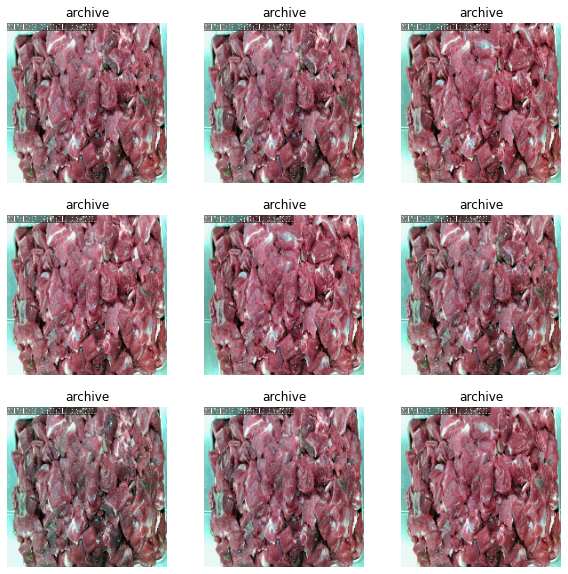

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Przetworzenie danych:
Jeśli chodzi o przetwarzanie danych, tutaj nie ma dużo do opowiadania. Dane zostały wczytane, sprawdzone. Podzielone na train_ds oraz val_ds. Następnie dane zostały przez nas znormalizowane. 
Po przejrzeniu wyrywkowych danych zawartych w moim zbiorze, doszliśmy do wniosku, że kompresowanie czy też zmiany odcieni (lub wybijanie jakiś na pierwszy plan) na różnych zdjęciach powoduje inne zmiany. Dzięki użyciu “naturalnych” zdjęć, program może być wykorzystywany do kolejnych zbiorów danych.

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
48/48 [==============================] - 21s 421ms/step - loss: 0.0642 - accuracy: 0.9789 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
48/48 [==============================] - 18s 378ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
48/48 [==============================] - 18s 370ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
48/48 [==============================] - 20s 414ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
48/48 [==============================] - 18s 381ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
48/48 [==============================] - 18s 374ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
48/48 [==============================] - 18s 372ms/step - loss: 0.0000e+00 - accuracy: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
path = str(random.choice(os.listdir("Fresh/")))
image_fresh = Image.open("Fresh/"+path)
resized_image_fresh = image_fresh.resize((180,180))
image_fresh


In [ ]:
img_array = tf.keras.utils.img_to_array(resized_image_fresh)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
path = str(random.choice(os.listdir("Spoiled/")))
image_spoiled = Image.open("Spoiled/"+path)
resized_image_spoiled = image_spoiled.resize((180,180))
image_spoiled

In [ ]:
img_array = tf.keras.utils.img_to_array(resized_image_spoiled)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)